#Disciplina: Processamento de Grandes Volumes de Dados

Prof. Francisco Pereira Junior

Profa. Rosangela Marquesone

O objetivo desse notebook é apresentar exemplos de aplicação do MLLib, para o processamento de modelos de aprendizado de máquina.

Para isso, os seguintes exemplos serão apresentados:

- Instalação e configuração do Apache Spark
- Utilização do MLLib para algoritmos de regressão logística
- Utilização do MLLib para algoritmos de clusterização com K-Means

## Parte I - Instalando o Spark

### Fazendo o download do Java

In [ ]:
#download do Java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

### Fazendo o download do spark

In [ ]:
#download do spark
!wget https://archive.apache.org/dist/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz

--2022-05-13 14:10:13--  https://archive.apache.org/dist/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
Resolving archive.apache.org (archive.apache.org)... 138.201.131.134, 2a01:4f8:172:2ec5::2
Connecting to archive.apache.org (archive.apache.org)|138.201.131.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 233333392 (223M) [application/x-gzip]
Saving to: ‘spark-2.4.7-bin-hadoop2.7.tgz’

spark-2.4.7-bin-had 100%[===================>] 222.52M  24.0MB/s    in 21s     

2022-05-13 14:10:35 (10.4 MB/s) - ‘spark-2.4.7-bin-hadoop2.7.tgz’ saved [233333392/233333392]



### Descompactando o Spark

In [ ]:
#descompactando o spark
!tar -xf /content/spark-2.4.7-bin-hadoop2.7.tgz

### Instalando o findspark

A biblioteca findspark é utilizada para realizar a configuração do pyspark.

In [ ]:
#instalando o findspark
!pip install -q findspark

In [ ]:
#importando as bilbiotecas
import findspark
import os

In [ ]:
#configurando a variável de ambiente do Java
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

In [ ]:
#configurando a variável de ambiente do Spark
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

In [ ]:
#informando a pasta raíz do spark
findspark.init("spark-2.4.7-bin-hadoop2.7")

### Iniciando uma sessão do spark em modo local

In [ ]:
#iniciando uma sessão do Spark
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
#importando as bibliotecas do spark e do pandas
from pyspark import SparkContext
from pyspark.sql import SQLContext
import pandas as pd

In [ ]:
#iniciando o objeto SQLContext
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

## Parte II - Utilizando o Spark MLLib para Regressão Logística

Nesse exemplo utilizaremos uma base de dados de uma operadora de telecomunicação, com o objetivo de prever o churn, ou seja, a desistência do usuário em um serviço.

Para essa atividade, utilizaremos o algoritmo de regressão logística, disponibilizado pelo Spark MLLib.

### Fazendo o download de dados

Link para download do dataset: https://raw.githubusercontent.com/bensadeghi/pyspark-churn-prediction/master/data/churn-bigml-80.csv

### Carregando o dataset

In [ ]:
#realizando o download dos dados
!wget https://raw.githubusercontent.com/bensadeghi/pyspark-churn-prediction/master/data/churn-bigml-80.csv

--2022-05-13 13:44:17--  https://raw.githubusercontent.com/bensadeghi/pyspark-churn-prediction/master/data/churn-bigml-80.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 223998 (219K) [text/plain]
Saving to: ‘churn-bigml-80.csv’

churn-bigml-80.csv  100%[===================>] 218.75K  --.-KB/s    in 0.03s   

2022-05-13 13:44:17 (8.24 MB/s) - ‘churn-bigml-80.csv’ saved [223998/223998]



In [ ]:
#carregando o dataset
df_train = sqlContext.read.load('churn-bigml-80.csv',
                               format='csv',
                               header='true',
                               inferSchema='true')

Uma das estratégias ofertadas pelo Spark, com foco em aumentar o desempenho da execução de operações sobre os dados é o método cache(), que permite guardar em memória os resultados dos dados obtidos por operações, para serem utilizados em consultas posteriores.

In [ ]:
#criando um cache dos dados
df_train.cache()

DataFrame[State: string, Account length: int, Area code: int, International plan: string, Voice mail plan: string, Number vmail messages: int, Total day minutes: double, Total day calls: int, Total day charge: double, Total eve minutes: double, Total eve calls: int, Total eve charge: double, Total night minutes: double, Total night calls: int, Total night charge: double, Total intl minutes: double, Total intl calls: int, Total intl charge: double, Customer service calls: int, Churn: boolean]

### Análise exploratória dos dados

In [ ]:
#visualizando o schema dos dados
df_train.printSchema()

root
 |-- State: string (nullable = true)
 |-- Account length: integer (nullable = true)
 |-- Area code: integer (nullable = true)
 |-- International plan: string (nullable = true)
 |-- Voice mail plan: string (nullable = true)
 |-- Number vmail messages: integer (nullable = true)
 |-- Total day minutes: double (nullable = true)
 |-- Total day calls: integer (nullable = true)
 |-- Total day charge: double (nullable = true)
 |-- Total eve minutes: double (nullable = true)
 |-- Total eve calls: integer (nullable = true)
 |-- Total eve charge: double (nullable = true)
 |-- Total night minutes: double (nullable = true)
 |-- Total night calls: integer (nullable = true)
 |-- Total night charge: double (nullable = true)
 |-- Total intl minutes: double (nullable = true)
 |-- Total intl calls: integer (nullable = true)
 |-- Total intl charge: double (nullable = true)
 |-- Customer service calls: integer (nullable = true)
 |-- Churn: boolean (nullable = true)



In [ ]:
#visualizando os top n registros utilizando o Pandas
pd.DataFrame(df_train.take(5), columns=df_train.columns)

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


### Verificando quantas observações existem em cada categoria

In [ ]:
#verificando a quantidade de observações em cada amostra
df_train.groupBy('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
| true|  388|
|false| 2278|
+-----+-----+



### Verificando as estatísticas das colunas

In [ ]:
#visualizando as estatísticas básicas das colunas
df_train.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
State,2666,None,None,AK,WY
Account length,2666,100.62040510127532,39.56397365334985,1,243
Area code,2666,437.43885971492875,42.521018019427174,408,510
International plan,2666,None,None,No,Yes
Voice mail plan,2666,None,None,No,Yes
Number vmail messages,2666,8.021755438859715,13.61227701829193,0,50
Total day minutes,2666,179.48162040510135,54.21035022086982,0.0,350.8
Total day calls,2666,100.31020255063765,19.988162186059512,0,160
Total day charge,2666,30.512404351087813,9.215732907163497,0.0,59.64


### Construindo um modelo de regressão logística

### Preparação dos dados

In [ ]:
#importando as bibliotecas
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import udf
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

As diversas transformções de features que o Spark oferece pode ser vista no seguinte link:

https://spark.apache.org/docs/latest/ml-features

In [ ]:
#aplicando a técnica OneHoteEncoder no atributo International plan
ipIndexer = StringIndexer(inputCol = 'International plan', 
                          outputCol = 'ipIndex')
ipEncoder = OneHotEncoder(inputCol = 'ipIndex', 
                          outputCol = 'ipVector')

In [ ]:
#selecionado as features que serão utilizadas
featureCols = ['Account length', 'ipVector', 
               'Number vmail messages', 'Total day minutes',
               'Total day calls', 'Total eve minutes', 
               'Total eve calls', 'Total night minutes', 
               'Total night calls', 'Total intl minutes', 
               'Total intl calls', 'Customer service calls']

In [ ]:
#criando o vetor de features
assembler = VectorAssembler(inputCols = featureCols, 
                            outputCol = 'features')

In [ ]:
#construindo o objeto de regressão logística
lre = LogisticRegression(maxIter = 20)

In [ ]:
#convertendo os dados para numérico
toNum = udf(lambda v: float(v), DoubleType())
df_train = df_train.withColumn('label', toNum(df_train['Churn'])).cache()

In [ ]:
#visualizando a coluna label
pd.DataFrame(df_train.take(10), columns=df_train.columns)

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn,label
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False,0.0
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False,0.0
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False,0.0
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False,0.0
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False,0.0
5,AL,118,510,Yes,No,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0,False,0.0
6,MA,121,510,No,Yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,False,0.0
7,MO,147,415,Yes,No,0,157.0,79,26.69,103.1,94,8.76,211.8,96,9.53,7.1,6,1.92,0,False,0.0
8,WV,141,415,Yes,Yes,37,258.6,84,43.96,222.0,111,18.87,326.4,97,14.69,11.2,5,3.02,0,False,0.0
9,RI,74,415,No,No,0,187.7,127,31.91,163.4,148,13.89,196.0,94,8.82,9.1,5,2.46,0,False,0.0


### Treinando o modelo

In [ ]:
#construindo um pipeline e treinando o modelo
pipeline = Pipeline(stages=[ipIndexer, ipEncoder, assembler, lre])
model = pipeline.fit(df_train)

### Testando o modelo

O dataset utilizado para o teste está disponível no seguinte link:

https://raw.githubusercontent.com/bensadeghi/pyspark-churn-prediction/master/data/churn-bigml-20.csv

In [ ]:
#realizando o download dos dados
!wget https://raw.githubusercontent.com/bensadeghi/pyspark-churn-prediction/master/data/churn-bigml-20.csv

--2021-06-14 14:29:44--  https://raw.githubusercontent.com/bensadeghi/pyspark-churn-prediction/master/data/churn-bigml-20.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56329 (55K) [text/plain]
Saving to: ‘churn-bigml-20.csv’

churn-bigml-20.csv  100%[===================>]  55.01K  --.-KB/s    in 0.01s   

2021-06-14 14:29:44 (5.16 MB/s) - ‘churn-bigml-20.csv’ saved [56329/56329]



In [ ]:
#carregando o dataset
df_test = sqlContext.read.load('churn-bigml-20.csv',
                               format='csv',
                               header='true',
                               inferSchema='true')

In [ ]:
#criando a coluna label
df_test.cache()
df_test = df_test.withColumn('label', toNum(df_test['Churn'])).cache()


In [ ]:
#testando o modelo
predictions = model.transform(df_test)

In [ ]:
#visualizando as predições
predictions.select("prediction", "label", "features").show(150)

+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       0.0|  0.0|[117.0,1.0,0.0,18...|
|       0.0|  1.0|[65.0,1.0,0.0,129...|
|       0.0|  1.0|[161.0,1.0,0.0,33...|
|       0.0|  0.0|[111.0,1.0,0.0,11...|
|       0.0|  0.0|[49.0,1.0,0.0,119...|
|       0.0|  0.0|[36.0,1.0,30.0,14...|
|       0.0|  0.0|[65.0,1.0,0.0,211...|
|       0.0|  1.0|[119.0,1.0,0.0,15...|
|       0.0|  0.0|[10.0,1.0,0.0,186...|
|       0.0|  0.0|[68.0,1.0,0.0,148...|
|       0.0|  0.0|[74.0,1.0,33.0,19...|
|       0.0|  0.0|[85.0,1.0,0.0,235...|
|       0.0|  0.0|[46.0,1.0,0.0,214...|
|       0.0|  0.0|[128.0,1.0,29.0,1...|
|       0.0|  1.0|[155.0,1.0,0.0,20...|
|       0.0|  0.0|[73.0,1.0,0.0,160...|
|       0.0|  1.0|[77.0,1.0,0.0,251...|
|       0.0|  0.0|[108.0,1.0,0.0,17...|
|       0.0|  0.0|[95.0,1.0,0.0,135...|
|       0.0|  0.0|[36.0,1.0,29.0,28...|
|       0.0|  0.0|[141.0,1.0,32.0,1...|
|       0.0|  0.0|[63.0,1.0,0.0,58....|


In [ ]:
#avaliando a acurácia
multi = MulticlassClassificationEvaluator(labelCol='label', 
                                          predictionCol='prediction', 
                                          metricName="accuracy")
accuracy = multi.evaluate(predictions)

In [ ]:
#apresentando a acurácia
print("Acurácia = %3.2f" % accuracy)

Acurácia = 0.85


In [ ]:
#visualizando a quantidade de registros
count = predictions.select("label").groupBy("label").count().toPandas()
print(count)

   label  count
0    0.0    572
1    1.0     95


In [ ]:
#preparando os dados para a matriz de confusão
y_true = predictions.select("label")
y_true = y_true.toPandas()
y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

In [ ]:
#construindo a matriz de confusão
cm = confusion_matrix(y_true, y_pred, normalize="true")
cm

array([[0.97202797, 0.02797203],
       [0.86315789, 0.13684211]])

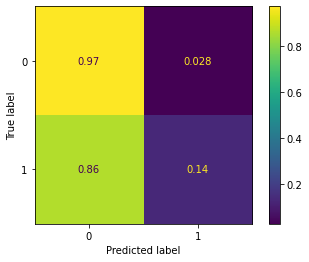

In [ ]:
#criando uma visualização da matriz de confusão
cmd = ConfusionMatrixDisplay(cm, display_labels=["0", "1"])
cmd.plot()

## Parte III - Utilizando o K-Means no MLLib

Descrição: um sistema da empresa foi invadido e muitos dados foram roubados. Porém, os metadados de cada sessão que os hackers usavam para se conectar foram registrados e estão disponíveis para análise. 

Observação: uma prática comum entre hackers é o tradeoff do job, de forma que os hackers realizam aproximadamente a mesma quantidade de ataques. 

Objetivo: Usar o algoritmo K-Means para identificar o número de hackers na invasão.

Base de dados: hack_data.csv


### Carregando e preparando os dados

In [ ]:
#importando as biliotecas
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import KMeans

In [ ]:
#realizando o download dos dados
!wget https://raw.githubusercontent.com/farhanafayez/PySpark-K-means-Clustering-ML/master/hack_data.csv

--2021-06-14 14:29:49--  https://raw.githubusercontent.com/farhanafayez/PySpark-K-means-Clustering-ML/master/hack_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14268 (14K) [text/plain]
Saving to: ‘hack_data.csv.1’

hack_data.csv.1     100%[===================>]  13.93K  --.-KB/s    in 0s      

2021-06-14 14:29:49 (53.3 MB/s) - ‘hack_data.csv.1’ saved [14268/14268]



In [ ]:
#carregando o dataset
df = spark.read.csv('hack_data.csv', inferSchema=True, header=True)
df.printSchema()

root
 |-- Session_Connection_Time: double (nullable = true)
 |-- Bytes Transferred: double (nullable = true)
 |-- Kali_Trace_Used: integer (nullable = true)
 |-- Servers_Corrupted: double (nullable = true)
 |-- Pages_Corrupted: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- WPM_Typing_Speed: double (nullable = true)



Descrição dos atributos:

* Session_Connection_Time: quanto tempo durou a sessão em minutos
* Bytes_Transferred: megabytes transferidos durante a sessão
* Kali_Trace_Used: se o hacker estava usando o Kali Linux
* Servers_Corrupted: número de servidores corrompidos durante o ataque
* Pages_Corrupted: número de páginas acessadas ilegalmente
* Localização: localização do ataque
* WPM_Typing_Speed: (words per minute) velocidade de digitação estimada com base nos logs da sessão


In [ ]:
#visualizando a qtd de linhas e colunas
print((df.count(),len(df.columns)))

(334, 7)


In [ ]:
#visualizando as estatísticas básicas
df.describe().show()

+-------+-----------------------+------------------+------------------+-----------------+------------------+-----------+------------------+
|summary|Session_Connection_Time| Bytes Transferred|   Kali_Trace_Used|Servers_Corrupted|   Pages_Corrupted|   Location|  WPM_Typing_Speed|
+-------+-----------------------+------------------+------------------+-----------------+------------------+-----------+------------------+
|  count|                    334|               334|               334|              334|               334|        334|               334|
|   mean|     30.008982035928145| 607.2452694610777|0.5119760479041916|5.258502994011977|10.838323353293413|       null|57.342395209580864|
| stddev|     14.088200614636158|286.33593163576757|0.5006065264451406| 2.30190693339697|  3.06352633036022|       null| 13.41106336843464|
|    min|                    1.0|              10.0|                 0|              1.0|               6.0|Afghanistan|              40.0|
|    max|           

In [ ]:
#visualizando os primeiros 10 registros
df.show(10)

+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+
|Session_Connection_Time|Bytes Transferred|Kali_Trace_Used|Servers_Corrupted|Pages_Corrupted|            Location|WPM_Typing_Speed|
+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+
|                    8.0|           391.09|              1|             2.96|            7.0|            Slovenia|           72.37|
|                   20.0|           720.99|              0|             3.04|            9.0|British Virgin Is...|           69.08|
|                   31.0|           356.32|              1|             3.71|            8.0|             Tokelau|           70.58|
|                    2.0|           228.08|              1|             2.48|            8.0|             Bolivia|            70.8|
|                   20.0|            408.5|              0|             3.57

In [ ]:
#criando o vetor de features
assembler = VectorAssembler(inputCols = ['Session_Connection_Time', 
 'Bytes Transferred',
 'Kali_Trace_Used',
 'Servers_Corrupted',
 'Pages_Corrupted',
 'WPM_Typing_Speed'], outputCol = 'features')

In [ ]:
#visualizando como ficou o dataframe
final_df = assembler.transform(df)
final_df.printSchema()

root
 |-- Session_Connection_Time: double (nullable = true)
 |-- Bytes Transferred: double (nullable = true)
 |-- Kali_Trace_Used: integer (nullable = true)
 |-- Servers_Corrupted: double (nullable = true)
 |-- Pages_Corrupted: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- WPM_Typing_Speed: double (nullable = true)
 |-- features: vector (nullable = true)



In [ ]:
#aplicando a normalização dos dados
scaler = StandardScaler(inputCol = 'features', outputCol = 'scaledFeatures')
scaler_model = scaler.fit(final_df)

In [ ]:
#visualizando como ficou o dataframe
final_df = scaler_model.transform(final_df)
final_df.printSchema()

root
 |-- Session_Connection_Time: double (nullable = true)
 |-- Bytes Transferred: double (nullable = true)
 |-- Kali_Trace_Used: integer (nullable = true)
 |-- Servers_Corrupted: double (nullable = true)
 |-- Pages_Corrupted: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- WPM_Typing_Speed: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- scaledFeatures: vector (nullable = true)



In [ ]:
#visualizando o vetor normalizado
final_df.select('features','scaledFeatures').show(5, False)

+--------------------------------+------------------------------------------------------------------------------------------------------------------+
|features                        |scaledFeatures                                                                                                    |
+--------------------------------+------------------------------------------------------------------------------------------------------------------+
|[8.0,391.09,1.0,2.96,7.0,72.37] |[0.5678510846650524,1.3658432518957642,1.9975768336483841,1.2858903881191532,2.2849485348398866,5.396290958577967]|
|[20.0,720.99,0.0,3.04,9.0,69.08]|[1.419627711662631,2.517986463945197,0.0,1.320644182392644,2.9377909733655687,5.150971112595909]                  |
|[31.0,356.32,1.0,3.71,8.0,70.58]|[2.2004229530770782,1.2444124562517545,1.9975768336483841,1.611707209433128,2.6113697541027276,5.262819066691072] |
|[2.0,228.08,1.0,2.48,8.0,70.8]  |[0.1419627711662631,0.7965469045293562,1.9975768336483841,1.077367

In [ ]:
#visualizando todo o dataframe
final_df.show(5)

+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+--------------------+--------------------+
|Session_Connection_Time|Bytes Transferred|Kali_Trace_Used|Servers_Corrupted|Pages_Corrupted|            Location|WPM_Typing_Speed|            features|      scaledFeatures|
+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+--------------------+--------------------+
|                    8.0|           391.09|              1|             2.96|            7.0|            Slovenia|           72.37|[8.0,391.09,1.0,2...|[0.56785108466505...|
|                   20.0|           720.99|              0|             3.04|            9.0|British Virgin Is...|           69.08|[20.0,720.99,0.0,...|[1.41962771166263...|
|                   31.0|           356.32|              1|             3.71|            8.0|             Tokelau|           70.58

### Aplicando o K-Means sobre os dados preparados

Para avaliar a suspeita de que tenha havido dois ou três hackers envolvidos, podemos criar dois modelos K-Means:

* Um modelo será inicializado com dois clusters (k = 2),
* Outro será inicializado com três grupos (k = 3).


In [ ]:
#construindo o objeto para clusterização com k = 2
kmeans2 = KMeans(featuresCol = 'scaledFeatures', k=2)

In [ ]:
#construindo o objeto para clusterização com k = 3
kmeans3 = KMeans(featuresCol = 'scaledFeatures', k=3)

In [ ]:
#construindo o modelo k2
model_k2 = kmeans2.fit(final_df)

In [ ]:
#construindo o modelo k3
model_k3 = kmeans3.fit(final_df)

O método computeCost() retorna o custo das médias K (soma dos quadrados das distâncias dos pontos ao centroide mais próximo).

O melhor número para a quantidade de clusters é quando a adição de um novo cluster não muda significativamente a função de custo (método elbow)


In [ ]:
#visualizando o custo computacional
print('Soma do quadrado das distâncias - K2:', 
      model_k2.computeCost(final_df))
print('Soma do quadrado das distâncias - K3:', 
      model_k3.computeCost(final_df))

Soma do quadrado das distâncias - K2: 601.7707512676716
Soma do quadrado das distâncias - K3: 434.1492898715845


In [ ]:
#visualizando com outros valores atribuídos ao k
for k in range(2,9):
  kmeans = KMeans(featuresCol='scaledFeatures',k=k)
  model = kmeans.fit(final_df)
  cost = model.computeCost(final_df)
  print("Com K={}".format(k))
  print("Soma do quadrado das distâncias = " + str(cost))
  print('--'*30)

Com K=2
Soma do quadrado das distâncias = 601.7707512676716
------------------------------------------------------------
Com K=3
Soma do quadrado das distâncias = 434.1492898715845
------------------------------------------------------------
Com K=4
Soma do quadrado das distâncias = 267.1336116887891
------------------------------------------------------------
Com K=5
Soma do quadrado das distâncias = 250.79688411563797
------------------------------------------------------------
Com K=6
Soma do quadrado das distâncias = 232.62054194167905
------------------------------------------------------------
Com K=7
Soma do quadrado das distâncias = 216.47738554068349
------------------------------------------------------------
Com K=8
Soma do quadrado das distâncias = 196.57053361253577
------------------------------------------------------------


In [ ]:
#visualizando os resultados do modelo com k=3
model_k3.transform(final_df).groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  167|
|         2|   83|
|         0|   84|
+----------+-----+



ANÁLISE: 

* Percebe-se que o número de instâncias não é semelhante entre os três clusters.
* Como isso contraria as informações básicas de que os hackers negociam os ataques, parece improvável a participação de três hackers.

Portanto, vamos verificar as classificações no caso de dois clusters.

In [ ]:
#visualizando os resultados do modelo com k=3
model_k2.transform(final_df).groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  167|
|         0|  167|
+----------+-----+



ANÁLISE: 
* Os dois clusters aqui têm exatamente o mesmo número de instâncias atribuídos a eles.
* Isso se alinha perfeitamente à ideia de hackers negociando ataques.
Portanto, é altamente provável que apenas dois hackers tenham se envolvido nos ataques.


Parabéns! Ao chegar até aqui, você conseguiu executar exemplos de algoritmos de aprendizado de máquina utilizando o Apache Spark MLLib.